# Transfer learning and model evaluation using different hyperparameters and their data characteristics

The objective of this notebook is to:
- identify the type of data we are ingesting
- test the model with different hyperparameters and calculate each test root mean square error per cristaline system
- present the best 3 models and their performance by category(cristaline system)

In order to achieve this objectives we are going to use the notebooks made/provided by Dr.Juan Ivan Gomez and his analysis of features using transfer learnging techniques

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression as LR

We retrieve the features obtained in the previous notebooks

In [3]:
# RECUERDA MOVERLE A LOS PATHS.
directorio = "C:/Users/marit/Documents/UPY Estancia I/latpar_project/LatPars_SuperModel/"

In [4]:
hfxrd = np.load(directorio + 'hf_0100.npy')
y = np.load("C:/Users/marit/Documents/UPY Estancia I/latpar_project/latpars.npy")

In [5]:
hfxrd.shape

(231632, 480)

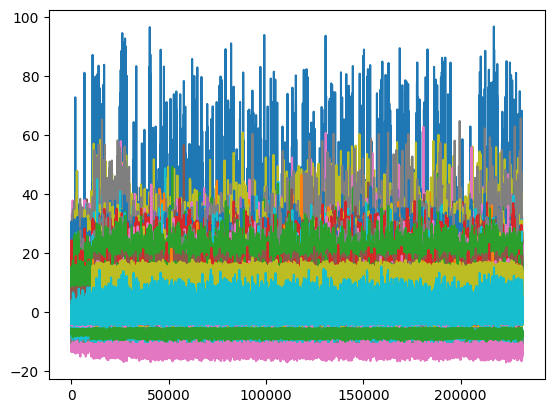

In [6]:
plt.plot(hfxrd)
plt.show()

In [8]:
for row in range(db.shape[0]):    
    db.at[row,'name'] = db['name'][row][:7]

In [9]:
dftest = pd.read_csv(directorio + 'dftest.csv')
dftraval = pd.read_csv(directorio + 'dftraval.csv')

for row in range(dftest.shape[0]):
    dftest.at[row, 'name'] = dftest['name'][row][:7]
    
for row in range(dftraval.shape[0]):
    dftraval.at[row, 'name'] = dftraval['name'][row][:7]

ntest = dftest.shape[0]//4
ntraval = dftraval.shape[0]//4

dftest = dftest.iloc[:ntest,:].reset_index(drop=True)
dftraval = dftraval.iloc[:ntraval,:].reset_index(drop=True)

idxtraval = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftraval.name.values])].index]
idxtest = [i for i in db.loc[db.name.isin([i.split('_')[0] for i in dftest.name.values])].index]

hftest = hfxrd[idxtest]
hftraval = hfxrd[idxtraval]

ytest = y[idxtest]
ytraval = y[idxtraval]

In [10]:
sgdiccio = pd.read_csv(r"C:/Users/marit/Documents/UPY Estancia I/latpar_project/sgnum_cif.csv")
sgdiccio = {k:v for k,v in zip(sgdiccio.cif.values, sgdiccio.sgnum.values)}

dbtest = db.take(idxtest).reset_index(drop=True)
dbtraval = db.take(idxtraval).reset_index(drop=True)

dbtest['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtest.name.values]
dbtraval['sgnum'] = [sgdiccio.get(int(i), None) for i in dbtraval.name.values]

In [11]:
cs = dict()

for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;
        

In [12]:
dbtest['cs'] = [cs.get(i, None) for i in dbtest.sgnum.values]
dbtraval['cs'] = [cs.get(i, None) for i in dbtraval.sgnum.values]

After all the preprocess of the data we retrieve the extracted features after processing the diffraction patterns

Following the models extension method we retrieve the orthonormal vectors to represent the crystal systems and the space groups where each crystal system will be represented as a 16-dimensional vector. We fix that length to have a 400-dimensional vector after adding the extracted features.

In [13]:
orthoset = scipy.stats.ortho_group.rvs(32, random_state=3451)
csos_test = orthoset[dbtest.cs.values]
csos_traval = orthoset[dbtraval.cs.values]

Each space group will be represented as a 230-dimensional vector.

In [14]:
sgoset = scipy.stats.ortho_group.rvs(230, random_state=3451)
sgos_traval = sgoset[dbtraval.sgnum.values-1]
sgos_test = sgoset[dbtest.sgnum.values-1]

Now we are going to evaluate the model provided by Doc.Juan Ivan Gomez with the raw extracted features and calculate its srme in each system in order to provide valuable insights about the performance of the model.

In [29]:
# AQUI CAMBIE EL ARGUMENTO QUE SE LE PASA A LA FUNCION TF.KERAS.INPUT PARA QUE CHAMBEE.

def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input(shape=(features,))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)


In [16]:
features = hftraval.shape[-1]

Now in order to keep changing and testing we are going to test the model 10 times with different randomized parameters in the multiples section and putting all relu activation functions within 0.15 and without dropout

In [35]:
# MODELO (RELATIVAMENTE MAS OPTIMO) PERO MAS CORTO SOLO PROBE CON POCAS EPOCAS.

import random

Models = {}

for i in range(5):
    multiples = [random.randint(1, 8), random.randint(1, 8)]
    print(multiples)
    nombre = f'raw_features_model_{i}'
    modelo = create_mlp(features=features, multiples=multiples, dropout=(random.random()*0.5), name=nombre)

    modelo.compile(loss='log_cosh', metrics=['MeanSquaredError'],
                   optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))

    history = modelo.fit(hftraval, ytraval, validation_data=(hftest, ytest), epochs=25, batch_size=64, verbose=1)
    
    Models[nombre] = {
        'history': history,
        'multiples': multiples,
        'model': modelo
    }


[8, 3]
Epoch 1/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 423s 130ms/step - MeanSquaredError: 1.0456 - loss: 0.2173 - val_MeanSquaredError: 0.5433 - val_loss: 0.1428
Epoch 2/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 353s 110ms/step - MeanSquaredError: 0.1225 - loss: 0.0517 - val_MeanSquaredError: 0.5035 - val_loss: 0.1277
Epoch 3/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 416s 130ms/step - MeanSquaredError: 0.0933 - loss: 0.0398 - val_MeanSquaredError: 0.5042 - val_loss: 0.1291
Epoch 4/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 417s 122ms/step - MeanSquaredError: 0.0836 - loss: 0.0356 - val_MeanSquaredError: 0.4858 - val_loss: 0.1214
Epoch 5/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 417s 130ms/step - MeanSquaredError: 0.0786 - loss: 0.0332 - val_MeanSquaredError: 0.4816 - val_loss: 0.1199
Epoch 6/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 464s 137ms/step - MeanSquaredError: 0.0734 - loss: 0.0312 - val_MeanSquaredError: 0.4815 - val_loss: 0.1198
Epoch 7/25
3209/3209 ━━━━━━━━━━━━━━━━━━━━ 425s 132ms/step - MeanSquaredError: 0.0708 - loss: 

In [25]:
# AQUI TE DIGO QUE ME SURGIO LA DUDA DE COMO LOS IBAMOS A PROBAR PARA VER QUE TAN BUENO ERAN PREDICIENDO Y VI COSAS.
print(Models)

{'raw_features_model_0': {'history': <keras.src.callbacks.history.History object at 0x000002F4B9004170>, 'multiples': [3, 2], 'model': <Functional name=raw_features_model_0, built=True>}, 'raw_features_model_1': {'history': <keras.src.callbacks.history.History object at 0x000002F67D677E00>, 'multiples': [9, 2], 'model': <Functional name=raw_features_model_1, built=True>}, 'raw_features_model_2': {'history': <keras.src.callbacks.history.History object at 0x000002F4BE81E9C0>, 'multiples': [9, 5], 'model': <Functional name=raw_features_model_2, built=True>}, 'raw_features_model_3': {'history': <keras.src.callbacks.history.History object at 0x000002F4BAE46060>, 'multiples': [1, 6], 'model': <Functional name=raw_features_model_3, built=True>}, 'raw_features_model_4': {'history': <keras.src.callbacks.history.History object at 0x000002F4C28AD430>, 'multiples': [5, 1], 'model': <Functional name=raw_features_model_4, built=True>}}


Now with the space groups

In [39]:
# Y YA NO SEGUI JUGANDO PQ VI QUE ERA BASICAMENTE LO MISMO.

xtest = np.concatenate((hftest, sgos_test), axis=-1)
xtraval = np.concatenate((hftraval, sgos_traval), axis=-1)

In [40]:
import random

Models = {}

for i in range(5):
    multiples = [random.randint(1,8), random.randint(1,8)]
    print(multiples)
    nombre = f'spacegroups_features_model_{i}'
    modelo = create_mlp(features = features, multiples = multiples, dropout = (random.random()*0.5), name=nombre)
    
    summary = modelo.summary()
    
    modelo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, learning_rate=1e-3, decay=1e-8,))
    
    history = tf.keras.callbacks.History()

    
    epochs = 25
    batch_size = 64
    verbose=1
    saveas = 'new_model_crystal_system'
    
    data = modelo.fit(xtraval,ytraval, validation_data=(xtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[history],shuffle=True, verbose=verbose)
    
    Models[nombre] = {
        'history': history,
        'multiples': multiples,
        'history_data': data,
        'model': modelo
    }    

[7, 7]


Model: "spacegroups_features_model_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)   │ (None, 480)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_104 (Dense)             │ (None, 3360)              │       1,616,160 │ input_layer_26[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_78        │ (None, 3360)              │           6,720 │ dense_104[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_52 (LeakyReLU)    │ (None, 3360)              │               0 │ layer_normalization_78[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_52 (Dropout)          │ (None, 3360)              │               0 │ leaky_re_lu_52[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_105 (Dense)             │ (None, 3360)              │      11,292,960 │ dropout_52[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_106 (Dense)             │ (None, 3360)              │       1,616,160 │ input_layer_26[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_79        │ (None, 3360)              │           6,720 │ dense_105[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_80        │ (None, 3360)              │           6,720 │ dense_106[0][0]            │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_26 (Add)                  │ (None, 3360)              │               0 │ layer_normalization_79[0]… │
│                               │                           │                 │ layer_normalization_80[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_53 (LeakyReLU)    │ (None, 3360)              │               0 │ add_26[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_53 (Dropout)          │ (None, 3360)              │               0 │ leaky_re_lu_53[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_107 (Dense)             │ (None, 6)                 │          20,166 │ dropout_53[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 14,565,606 (55.56 MB)

 Trainable params: 14,565,606 (55.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


ValueError: Input 0 of layer "spacegroups_features_model_0" is incompatible with the layer: expected shape=(None, 480), found shape=(None, 710)

Now with the crystal system groups

In [ ]:
xtest = np.concatenate((hftest, csos_test), axis=-1)
xtraval = np.concatenate((hftraval, csos_traval), axis=-1)

In [ ]:
import random

Models = {}

for i in range(5):
    multiples = [random.randint(1,8), random.randint(1,8)]
    print(multiples)
    nombre = f'crystalsystem_features_model_{i}'
    modelo = create_mlp(features = features, multiples = multiples, dropout = (random.random()*0.5), name=nombre)
    
    summary = modelo.summary()
    
    modelo.compile(loss='log_cosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))
    
    history = tf.keras.callbacks.History()

    
    epochs = 25
    batch_size = 64
    verbose=1
    saveas = 'new_model_crystal_system'
    
    data = modelo.fit(xtraval,ytraval, validation_data=(xtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[history],shuffle=True, verbose=verbose)
    
    Models[nombre] = {
        'history': history,
        'multiples': multiples,
        'history_data': data,
        'model': modelo
    }    